In [2]:
#!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O /tmp/cats_and_dogs_filtered.zip
!curl https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip --output /tmp/cats_and_dogs_filtered.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.4M  100 65.4M    0     0  11.5M      0  0:00:05  0:00:05 --:--:-- 13.3M


In [3]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import matplotlib.pyplot as plt

2024-08-06 14:32:23.594528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/gennai/Library/Python/3.7/lib/python/site-packages/urllib3/__init__.py:38: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.0'. See: https://github.com/urllib3/urllib3/issues/3020
  exceptions.NotOpenSSLWarning,


In [4]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [6]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

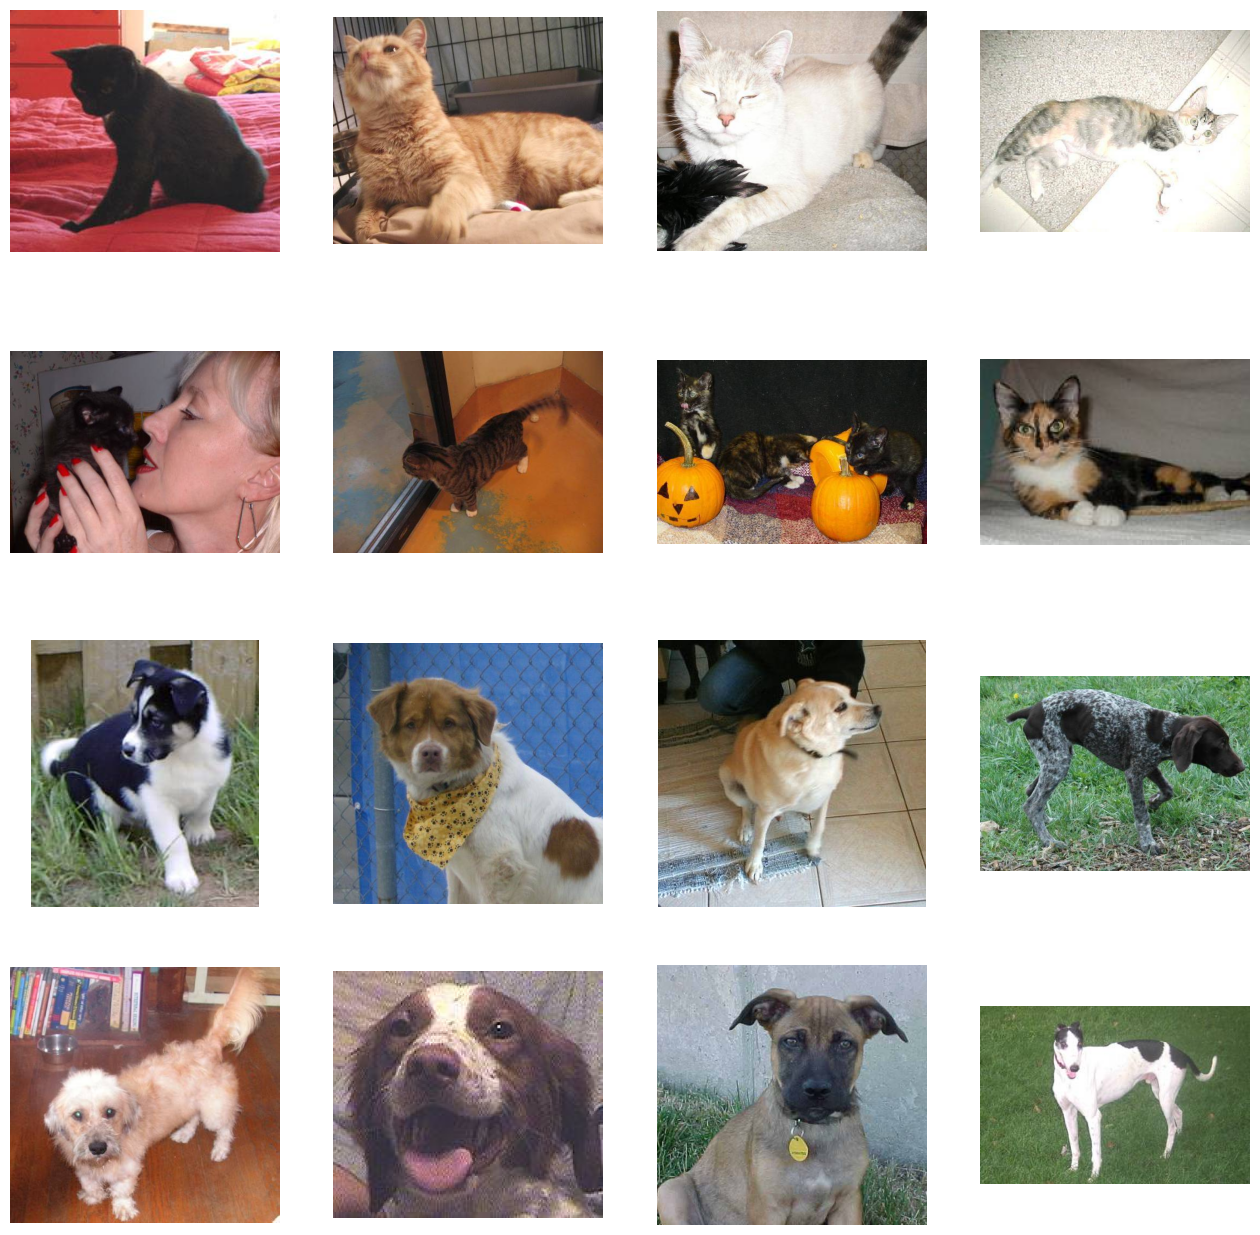

In [7]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )


next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[ pic_index-8:pic_index]
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [8]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1.0/255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [9]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')
base_model.summary()

2024-08-06 14:34:14.319376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
for layer in base_model.layers:
    layer.trainable = False

In [12]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])


In [13]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)

Epoch 1/10
100/100 [==============================] - 611s 6s/step - loss: 0.7353 - acc: 0.6645 - val_loss: 0.4168 - val_acc: 0.7940
Epoch 2/10
100/100 [==============================] - 529s 5s/step - loss: 0.5100 - acc: 0.7585 - val_loss: 0.3033 - val_acc: 0.8640
Epoch 3/10
100/100 [==============================] - 544s 5s/step - loss: 0.4255 - acc: 0.8055 - val_loss: 0.2744 - val_acc: 0.8790
Epoch 4/10
 10/100 [==>...........................] - ETA: 7:52 - loss: 0.3782 - acc: 0.8200

KeyboardInterrupt: 

In [30]:
test_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 1, class_mode = "binary", target_size = (224, 224))
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)


layer_names = [layer.name for layer in model.layers]
layer_names

Found 1000 images belonging to 2 classes.


/Users/gennai/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


10/10 [==============================] - 180s 18s/step
[[8.95410955e-01]
 [1.13228694e-01]
 [9.86925662e-01]
 [6.75381958e-01]
 [2.89587080e-01]
 [9.93861258e-01]
 [9.90201890e-01]
 [1.14505328e-02]
 [9.69342828e-01]
 [1.82325900e-01]
 [9.96759832e-01]
 [7.85185620e-02]
 [7.51591427e-03]
 [3.52696151e-01]
 [1.91380650e-01]
 [2.33005270e-01]
 [9.90835011e-01]
 [1.31719997e-02]
 [9.85167205e-01]
 [1.01971894e-03]
 [9.92455900e-01]
 [8.93150389e-01]
 [3.55774879e-01]
 [9.98709142e-01]
 [8.57340336e-01]
 [9.99969959e-01]
 [6.25327080e-02]
 [5.83420508e-02]
 [9.14850533e-01]
 [8.57275844e-01]
 [1.69639841e-01]
 [9.98479664e-01]
 [2.98045456e-01]
 [9.75724280e-01]
 [6.52427554e-01]
 [4.19197589e-01]
 [9.94344592e-01]
 [9.95865941e-01]
 [8.58492628e-02]
 [9.17005599e-01]
 [2.12050170e-01]
 [8.02137673e-01]
 [6.37930632e-02]
 [9.96817708e-01]
 [2.81249080e-02]
 [6.17135130e-03]
 [9.24139202e-01]
 [1.31116197e-01]
 [9.98502970e-01]
 [4.46388990e-01]
 [4.45059806e-01]
 [9.96912837e-01]
 [2.90283

['input_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten',
 'dense',
 'dropout',
 'dense_1']

In [35]:
import numpy as np
print(pred)
labels = (train_generator.filenames)
print(labels)




[[8.95410955e-01]
 [1.13228694e-01]
 [9.86925662e-01]
 [6.75381958e-01]
 [2.89587080e-01]
 [9.93861258e-01]
 [9.90201890e-01]
 [1.14505328e-02]
 [9.69342828e-01]
 [1.82325900e-01]
 [9.96759832e-01]
 [7.85185620e-02]
 [7.51591427e-03]
 [3.52696151e-01]
 [1.91380650e-01]
 [2.33005270e-01]
 [9.90835011e-01]
 [1.31719997e-02]
 [9.85167205e-01]
 [1.01971894e-03]
 [9.92455900e-01]
 [8.93150389e-01]
 [3.55774879e-01]
 [9.98709142e-01]
 [8.57340336e-01]
 [9.99969959e-01]
 [6.25327080e-02]
 [5.83420508e-02]
 [9.14850533e-01]
 [8.57275844e-01]
 [1.69639841e-01]
 [9.98479664e-01]
 [2.98045456e-01]
 [9.75724280e-01]
 [6.52427554e-01]
 [4.19197589e-01]
 [9.94344592e-01]
 [9.95865941e-01]
 [8.58492628e-02]
 [9.17005599e-01]
 [2.12050170e-01]
 [8.02137673e-01]
 [6.37930632e-02]
 [9.96817708e-01]
 [2.81249080e-02]
 [6.17135130e-03]
 [9.24139202e-01]
 [1.31116197e-01]
 [9.98502970e-01]
 [4.46388990e-01]
 [4.45059806e-01]
 [9.96912837e-01]
 [2.90283710e-01]
 [3.27964015e-02]
 [1.62099563e-02]
 [9.648505

In [14]:
layer_outputs = [layer.output for layer in model.layers]
print(len(layer_outputs))


23


In [15]:
feature_map_model = tf.keras.models.Model(model.input, layer_outputs[17])

Found 1000 images belonging to 2 classes.


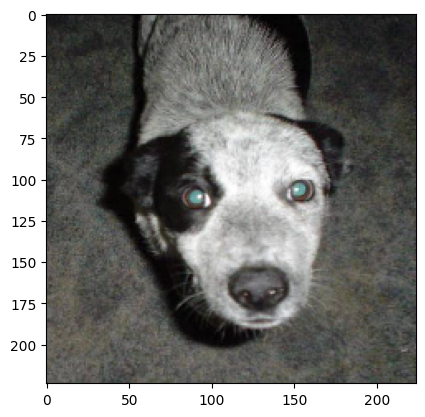

In [16]:
test_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 1, class_mode = None, target_size = (224, 224))
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
myImage = test_generator[0]
plt.imshow(myImage[0])
plt.show()


block2_conv2/Relu:0
1/1 [==============================] - 0s 108ms/step
(1, 112, 112, 128)


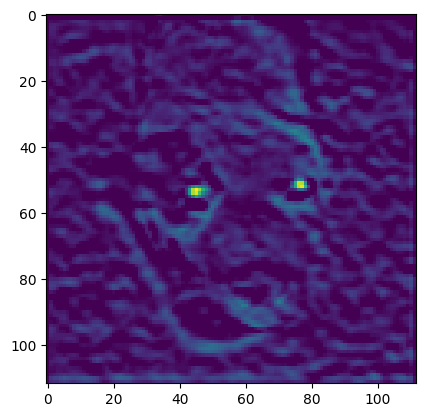

In [40]:
feature_map_model = tf.keras.models.Model(model.input, layer_outputs[5])
print(layer_outputs[5].name)
feature_maps = feature_map_model.predict(myImage,verbose=1)
print(feature_maps.shape)
plt.imshow(feature_maps[0,:,:,63])
plt.show()

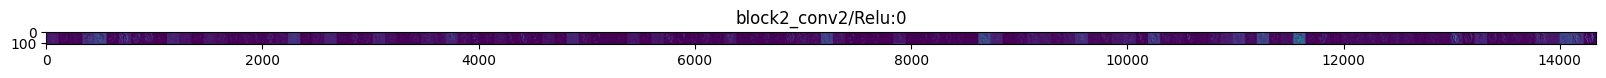

In [41]:
import numpy as np
k = feature_maps.shape[-1]
size= feature_maps.shape[1]
scale = 20. / k
image_belt = np.zeros((size, size * k))
for i in range(k):
  feature_image = feature_maps[0, :, :, i]
  image_belt[:, i * size : (i + 1) * size] = feature_image

plt.figure( figsize=(scale * k, scale) )
plt.title ( layer_outputs[5].name )
plt.grid  ( False )
plt.imshow(image_belt , aspect='auto')